In [1]:
%matplotlib ipympl

import sys

"""

Input:

#.#####
#.....#
#>....#
#.....#
#...v.#
#.....#
#####.#

The walls of the valley are drawn as #; everything else is ground. Clear ground - where there is currently no blizzard - is drawn as .. Otherwise, blizzards are drawn with an arrow indicating their direction of motion: up (^), down (v), left (<), or right (>).

The above map includes two blizzards, one moving right (>) and one moving down (v). In one minute, each blizzard moves one position in the direction it is pointing:

#.#####
#.....#
#.>...#
#.....#
#.....#
#...v.#
#####.#

Due to conservation of blizzard energy, as a blizzard reaches the wall of the valley, a new blizzard forms on the opposite side of the valley moving in the same direction. After another minute, the bottom downward-moving blizzard has been replaced with a new downward-moving blizzard at the top of the valley instead:

#.#####
#...v.#
#..>..#
#.....#
#.....#
#.....#
#####.#

Because blizzards are made of tiny snowflakes, they pass right through each other. After another minute, both blizzards temporarily occupy the same position, marked 2:

#.#####
#.....#
#...2.#
#.....#
#.....#
#.....#
#####.#

After another minute, the situation resolves itself, giving each blizzard back its personal space:

#.#####
#.....#
#....>#
#...v.#
#.....#
#.....#
#####.#

Finally, after yet another minute, the rightward-facing blizzard on the right is replaced with a new one on the left facing the same direction:

#.#####
#.....#
#>....#
#.....#
#...v.#
#.....#
#####.#

Here is a more complex example:

#.######
#>>.<^<#
#.<..<<#
#>v.><>#
#<^v^^>#
######.#

Your expedition begins in the only non-wall position in the top row and needs to reach the only non-wall position in the bottom row. On each minute, you can move up, down, left, or right, or you can wait in place. You and the blizzards act simultaneously, and you cannot share a position with a blizzard.

"""
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
BLIZZARDS = {
    '^': 1 << 0,
    'v': 1 << 1,
    '<': 1 << 2,
    '>': 1 << 3
}
PERSON = {
    'E': 0, #1 << 5,
}
BLIZZARDS['ANY'] = BLIZZARDS['^'] | BLIZZARDS['v'] | BLIZZARDS['<'] | BLIZZARDS['>']
TERRAIN = {
    '#': 1 << 8,
    '.': 0,
}

# for less busy rendering
TERRAIN_AND_BLIZZARDS = {v: k for k, v in {**TERRAIN, **BLIZZARDS, **PERSON}.items()}
TERRAIN_AND_BLIZZARDS[0] = ' '
TERRAIN_AND_BLIZZARDS[1 << 8] = ' '

COLOR_MAP = {
    0: 'ivory',
    1 << 8: 'black',
    1 << 5: 'red',
    1 << 0: 'Aqua', # up 
    1 << 1: 'Aquamarine', # down
    1 << 2: 'DarkTurquoise', # left
    1 << 3: 'PowderBlue', # right
    1 << 0 | 1 << 1: 'DodgerBlue',
    1 << 0 | 1 << 2: 'DodgerBlue',
    1 << 0 | 1 << 3: 'DodgerBlue',
    1 << 1 | 1 << 2: 'DodgerBlue',
    1 << 1 | 1 << 3: 'DodgerBlue',
    1 << 2 | 1 << 3: 'DodgerBlue',
    1 << 0 | 1 << 1 | 1 << 2: 'RoyalBlue',
    1 << 0 | 1 << 1 | 1 << 3: 'RoyalBlue',
    1 << 0 | 1 << 2 | 1 << 3: 'RoyalBlue',
    1 << 1 | 1 << 2 | 1 << 3: 'RoyalBlue',
    1 << 0 | 1 << 1 | 1 << 2 | 1 << 3: 'DarkBlue',
}

In [3]:
def parse_input_to_df(filename):
    with open(filename) as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]
    df = pd.DataFrame([list(line) for line in lines])
    df = df.replace(BLIZZARDS)
    df = df.replace(TERRAIN)
    df = df.replace(PERSON)
    df = df.astype(int)
    return df

df = parse_input_to_df('./day24-input.txt')


In [4]:



def get_next_blizzards(df):
    next_right = (df & BLIZZARDS['>']).shift(1, axis=1).fillna(0, downcast='infer')
    next_down = (df & BLIZZARDS['v']).shift(1, axis=0).fillna(0, downcast='infer')
    next_left = (df & BLIZZARDS['<']).shift(-1, axis=1).fillna(0, downcast='infer')
    next_up = (df & BLIZZARDS['^']).shift(-1, axis=0).fillna(0, downcast='infer')
    next_blizzards = next_right | next_down | next_left | next_up

    block_col = df.shape[1] - 1
    block_row = df.shape[0] - 1

    # wrap around, take all of the last column and put it in the second column
    next_blizzards[1] = next_blizzards[1] | next_blizzards[block_col]
    next_blizzards[block_col] = 0
    # wrap around, take all of the last row and put it in the second row
    next_blizzards.loc[1] = next_blizzards.loc[1] | next_blizzards.loc[block_row]
    next_blizzards.loc[block_row] = 0
    # wrap around, take all of the first column and put it in the second to last column
    next_blizzards[block_col - 1] = next_blizzards[block_col - 1] | next_blizzards[0]
    next_blizzards[0] = 0
    # wrap around, take all of the first row and put it in the second to last row
    next_blizzards.loc[block_row - 1] = next_blizzards.loc[block_row - 1] | next_blizzards.loc[0]
    next_blizzards.loc[0] = 0

    return next_blizzards

def advance(df, debug_prt = False):
    df = df.copy()
    if debug_prt: print('---')
    blizzards = df & BLIZZARDS['ANY']
    next_blizzards = get_next_blizzards(df)
    if debug_prt: display(df.replace(TERRAIN_AND_BLIZZARDS), blizzards.replace(TERRAIN_AND_BLIZZARDS), next_blizzards.replace(TERRAIN_AND_BLIZZARDS))
    df[df & blizzards > 0] = 0
    df : pd.DataFrame = df | next_blizzards
    if debug_prt: display(df.replace(TERRAIN_AND_BLIZZARDS))
    if debug_prt: print('---')
    return df


In [304]:
from time import sleep
from IPython.display import update_display

def run_test(df, iter = 100):
    test = df.copy()
    display(BLIZZARDS)
    display(test.replace(TERRAIN_AND_BLIZZARDS), display_id='test')
    for _ in range(iter):
        test = advance(test)
        update_display(test.replace(TERRAIN_AND_BLIZZARDS), display_id='test')
        sleep(0.1)
        
run_test(df, 20)

{'^': 1, 'v': 2, '<': 4, '>': 8, 'ANY': 15}

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,,,,,,,,,,,...,,,,,,,,,,
1,,,v,,>,,>,^,<,3,...,,^,<,v,9,v,3,<,<,
2,,>,12,^,^,^,3,6,,7,...,,<,^,,,<,,,,
3,,,6,^,<,,,,v,,...,10,,,,9,,,7,,
4,,<,v,9,9,,>,5,10,^,...,<,14,<,5,,<,,,>,
5,,,,^,<,<,<,v,v,6,...,,ANY,,>,9,5,13,<,,
6,,>,v,<,^,10,,,,>,...,^,,11,9,^,v,^,,,
7,,,,,,^,,^,^,v,...,,,14,^,,,^,,<,
8,,>,12,10,<,13,3,^,v,<,...,<,,<,,,7,,,<,
9,,<,,^,3,,^,^,9,v,...,<,^,,,v,,^,,,


KeyboardInterrupt: 

In [5]:
import collections
import time

test = df.copy()

# display(test)

frames = collections.deque(maxlen=650)
frames.append(test)

#
# We're going to continue advancing the game until we find a loop
# We'll keep track of the last 200 frames, and we'll watch for the first frame to reappear
# If the second follows, and the third, and so on, we'll know we've found a loop
# We'll then advance the game to confirm the loop is complete
# If at any point the loop is broken, we'll reset our tracking
#
iter_max = 600

loop_watcher_idx = -1
loop_starter_idx = -1
loop = []
start_time = time.time()
for _ in range(iter_max):
    test = advance(test)

    if test.equals(frames[loop_watcher_idx + 1]):
        if loop_watcher_idx == -1:
            loop_starter_idx = len(frames) - 1
            display('Loop starter index is now {}'.format(loop_starter_idx))
        loop_watcher_idx += 1
        # display('Loop watcher index is now {}'.format(loop_watcher_idx))
        if loop_watcher_idx == loop_starter_idx:
            display("iter {} - Loop starter found, frames: {}".format(_, len(frames)))
            loop = list(frames)[:loop_starter_idx + 1]
            break
    elif loop_watcher_idx > -1:
        loop_starter_idx = -1
        loop_watcher_idx = -1
        display('Loop watcher index is now (Reset) {}'.format(loop_watcher_idx))

    frames.append(test)
end_time = time.time()

print('Loop length is {} after {}s'.format(len(loop), end_time - start_time))

'Loop starter index is now 299'

'iter 598 - Loop starter found, frames: 599'

Loop length is 300 after 25.127074003219604s


In [6]:
len(loop)

300

In [ ]:
# export each cell in the dataframe as a value in a dict keyed by its index/column position
def df_to_dict(df):
    d = {}
    for row in df.index:
        for col in df.columns:
            d[(row, col)] = df.loc[row, col]
    return d

In [ ]:
class BoardDrawing:
    def __init__(self, df) -> None:
        self.df = df.copy()
        self.G = nx.grid_2d_graph(self.df.shape[0], self.df.shape[1])
        self.pos = {(x,y):(y,-x) for x,y in self.G.nodes()}
        self.options = {
            'pos': self.pos,
            'edgecolors': 'lightgray',
            # 'node_color': 'lightgray',
            'node_size': 600,
            'with_labels': True,
            'labels': {},
            'node_color': []
        }

        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(6,4))

    def update_node_options(self):
        pos_dict = df_to_dict(self.df.replace(TERRAIN_AND_BLIZZARDS))
        self.options['labels'] = pos_dict
        self.options['node_color'] = [COLOR_MAP.get(v, 'lightgray') for v in self.df.values.flatten()]

    def draw(self):
        self.update_node_options()
        nx.draw(self.G, ax=self.ax, **self.options)
        self.ax.set_xticks([])
        self.ax.set_yticks([])

    def update(self, num):
        self.ax.clear()
        self.df = advance(self.df, self.G)
        self.draw()

    def animate(self, iter = 5):
        self.ani = animation.FuncAnimation(self.fig, self.update, frames=iter, interval=500, repeat=False)
        plt.show()

bd = BoardDrawing(df)
bd.draw()
# bd.animate(20)

In [7]:
# Our grid will have points x,y,z, where z is the loop index representing time
# For each step in loop, we will remove the nodes that are blocked by any blizzard
# Our source is person at time index 0, and our target is the exit position at the first available time index
# We will then find the shortest path from source to target

def get_loop_graph(loop):
    # Create a graph that is 3d with the z axis representing time
    # Only nodes that are open or have our person will be included
    # Every x,y,z node is connected to the x,y,z+1 node, the 4 cardinal neighbors at z+1
    G = nx.DiGraph()  

    # Add all the x,y,z nodes from the loop
    for z, df in enumerate(loop):
        for x in range(df.shape[0]):
            for y in range(df.shape[1]):
                G.add_node((x,y,z), color=COLOR_MAP.get(df.loc[x,y], 'fuschia'), value=df.loc[x,y])

    # Add all the edges (second, so that we can set up all the node attributes first
    for z, df in enumerate(loop):
        next_z = (z + 1) % len(loop)
        for x in range(df.shape[0]):
            for y in range(df.shape[1]):
                # If I'm a space, look around me at next_z for a space within the bounds of the grid
                if df.loc[x,y] == 0:
                    # Add edges to the next z level
                    if loop[next_z].loc[x,y] == 0:
                        G.add_edge((x,y,z), (x,y,next_z), color='lightgray')
                    # Add edges to the cardinal neighbors at next_z
                    if x > 0 and loop[next_z].loc[x-1,y] == 0:
                        G.add_edge((x,y,z), (x-1,y,next_z), color='lightgray')
                    if x < df.shape[0] - 1 and loop[next_z].loc[x+1,y] == 0:
                        G.add_edge((x,y,z), (x+1,y,next_z), color='lightgray')
                    if y > 0 and loop[next_z].loc[x,y-1] == 0:
                        G.add_edge((x,y,z), (x,y-1,next_z), color='lightgray')
                    if y < df.shape[1] - 1 and loop[next_z].loc[x,y+1] == 0:
                        G.add_edge((x,y,z), (x,y+1,next_z), color='lightgray')
                
    return G

In [8]:

plt.close('all')

G = get_loop_graph(loop)
print('Loop graph has {} nodes and {} edges'.format(len(G.nodes), len(G.edges)))



Loop graph has 1003200 nodes and 687721 edges


In [307]:

# Create array of colors for each z level
# colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']

# Get all nodes that have a z value plus or minus 1 of the current z_level
# z_level = 1
# z_level_nodes = [n for n in G.nodes if n[2] <= z_level + 1 and n[2] >= z_level - 1]
z_level_nodes = list(G.nodes)
# top_z_level = len(loop) - 1
# z_level_nodes = [n for n in G.nodes if n[2] <= 1 or n[2] >= top_z_level - 1]

xs, ys, zs = zip(*z_level_nodes)

# Create the figure and the 3D scatter plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
# color codes for a grayscale gradient for z_level_node markers with black centered on z_level
# gradient_colors = ['lightgray', 'gray', 'black', 'gray', 'lightgray']

ax.scatter(xs, ys, zs, s=20)

# Iterate through the edges of the graph and plot them
for u, v in G.edges:
    if u in z_level_nodes and v in z_level_nodes:
        x1, y1, z1 = u
        x2, y2, z2 = v
        ax.quiver(x1, y1, z1, x2-x1, y2-y1, z2-z1, arrow_length_ratio=0.3)

# plt.show()

KeyboardInterrupt: 

In [9]:
import json

test = loop[0]

exit_row = test.shape[0] - 1
exit_col = test.loc[exit_row].eq(0).idxmax()
exit_point = (exit_row, exit_col)
entry_row = 0
entry_col = test.loc[entry_row].eq(0).idxmax()
entry_point = (entry_row, entry_col)

# min_steps = test.shape[0] + test.shape[1]

# We want to go from entry to exit, back from exit to entry, and back again from entry to exit

# Entry at time 0 to exit at unknown time
print("Going there...")
G = get_loop_graph(loop)
print('Loop graph has {} nodes and {} edges'.format(len(G.nodes), len(G.edges)))

print('Going from {} to {}'.format((*entry_point, 0), exit_point))
shortest_path = None
for i in range(len(loop)):
    try:
        path = nx.shortest_path(G, (*entry_point, 0), (*exit_point, i))
        if shortest_path is None or len(path) < len(shortest_path):
            shortest_path = path
    except nx.NetworkXNoPath as e:
        pass
print("Shortest path length: {}".format(len(shortest_path) - 1))
print("Went from {} to {}".format(shortest_path[0], shortest_path[-1]))

print()

start_point = shortest_path[-1]
print('Going from {} to {}'.format(start_point, entry_point))
shortest_loopback_path = None
for i in range(len(loop)):
    try:
        path = nx.shortest_path(G, start_point, (*entry_point, i))
        if shortest_loopback_path is None or len(path) < len(shortest_loopback_path):
            shortest_loopback_path = path
        # print('... length {}'.format(len(path)))
    except nx.NetworkXNoPath as e:
        # print('... Failed - No Path.')
        pass
    except nx.NodeNotFound as e:
        # print('... Failed - No Node.')
        pass
print("Shortest loopback path length: {}".format(len(shortest_loopback_path) - 1))
print("Went from {} to {}".format(shortest_loopback_path[0], shortest_loopback_path[-1]))

print()

start_point = shortest_loopback_path[-1]
print('Going from {} to {}'.format(start_point, entry_point))
shortest_backagain_path = None
for i in range(len(loop)):
    try:
        path = nx.shortest_path(G, start_point, (*exit_point, i))
        if shortest_backagain_path is None or len(path) < len(shortest_backagain_path):
            shortest_backagain_path = path
        # print('... length {}'.format(len(path)))
    except nx.NetworkXNoPath as e:
        # print('... Failed - No Path.')
        pass
    except nx.NodeNotFound as e:
        # print('... Failed - No Node.')
        pass
print("Shortest loopback path length: {}".format(len(shortest_backagain_path) - 1))
print("Went from {} to {}".format(shortest_backagain_path[0], shortest_backagain_path[-1]))



Going there...
Loop graph has 1003200 nodes and 687721 edges
Going from (0, 1, 0) to (21, 150)
Shortest path length: 343
Went from (0, 1, 0) to (21, 150, 43)

Going from (21, 150, 43) to (0, 1)
Shortest loopback path length: 320
Went from (21, 150, 43) to (0, 1, 63)

Going from (0, 1, 63) to (0, 1)
Shortest loopback path length: 297
Went from (0, 1, 63) to (21, 150, 60)


In [10]:
343+320+297

960

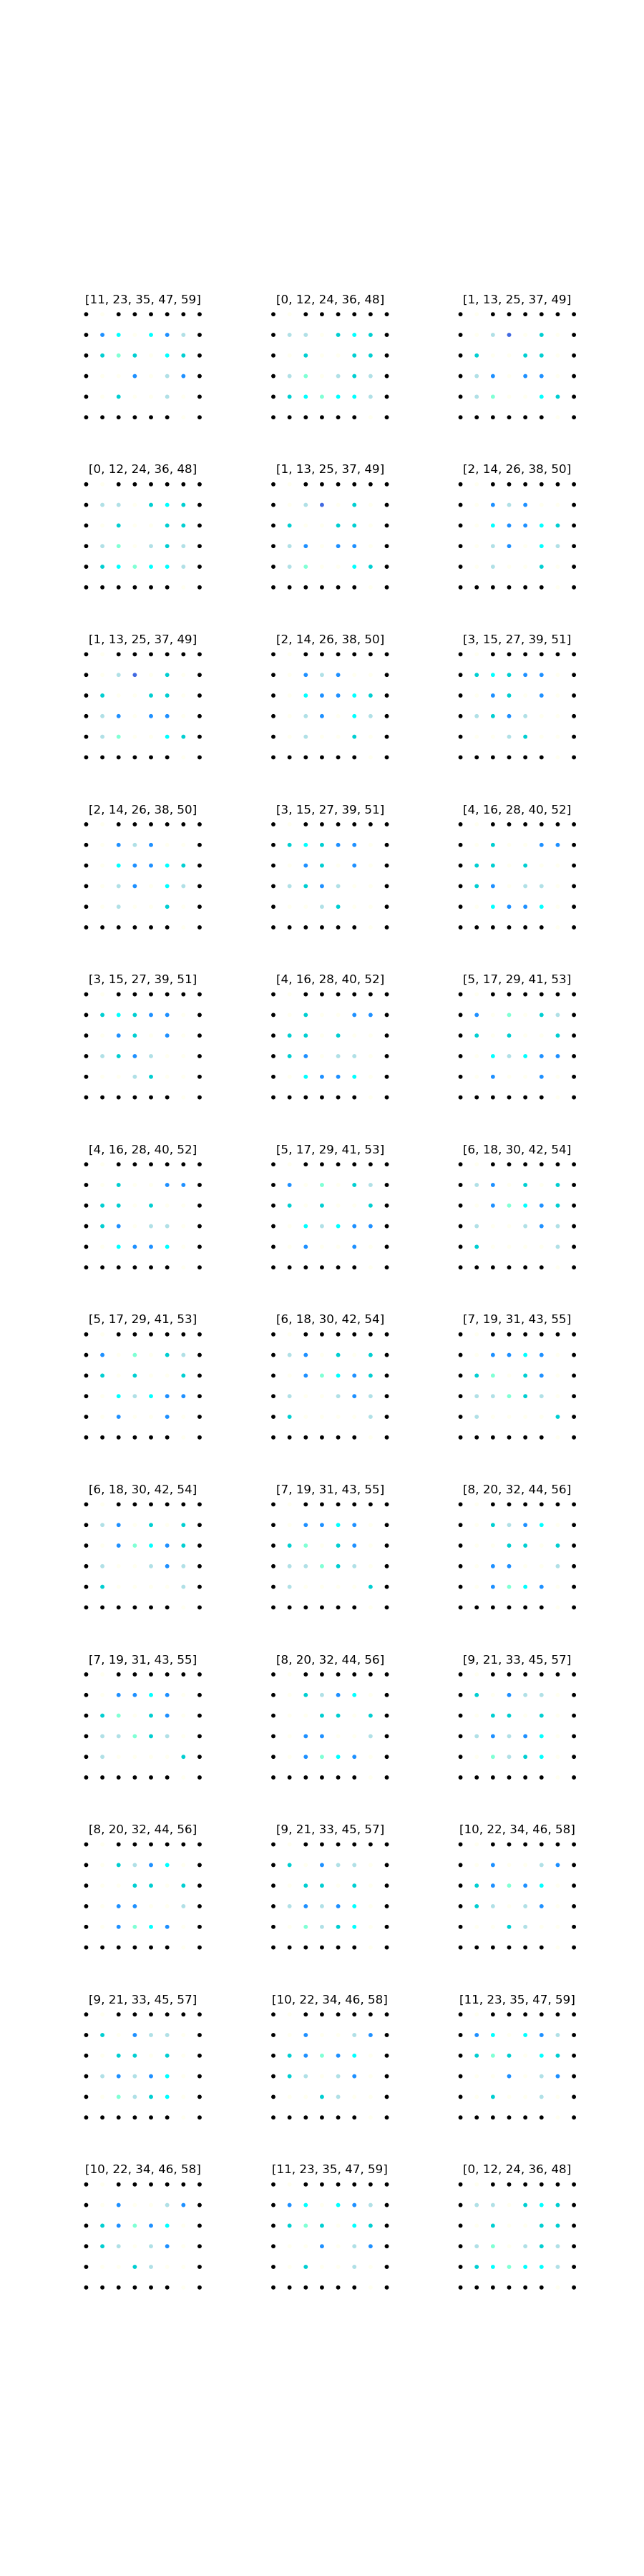

In [293]:
# I have a digraph G with nodes that have an x,y,timestep coordinate and edges between the nodes representing valid transitions
# I want to render each timestep as its own 2d graph with any of the nodes that have the same timestep
# I want to render a row of 3 graphs for each timestep, with the first column showing timestep-1, the second column showing timestep, and the third column showing timestep+1
# I want each graph to be 3x3 in size and have the same x,y limits for all of the graphs

plt.close('all')
unique_timesteps = sorted(list(set([n[2] for n in G.nodes()])))
loop_steps = len(unique_timesteps)

# x_min, x_max = (min([n[0] for n in G.nodes()]) - 1, max([n[0] for n in G.nodes()]) + 1)
# y_min, y_max = (min([n[1] for n in G.nodes()]) - 1, max([n[1] for n in G.nodes()]) + 1)

# fig, axs = plt.subplots(2, 3)
# fig, axs = plt.subplots(len(unique_timesteps), 3)

# Create a figure and a grid of subplots with 3 columns and len(unique_timesteps) rows. Each subplot will be a 3x3 grid.
fig = plt.figure(figsize=(9, 3 * len(unique_timesteps)))#, layout='tight')
gs = fig.add_gridspec(len(unique_timesteps), 3, wspace=0.5, hspace=0.5)
axs = gs.subplots(sharex=True, sharey=True)

rows = []
for i, timestep in enumerate(unique_timesteps):
    prev_timestamp = unique_timesteps[i - 1] if i > 0 else unique_timesteps[-1]
    next_timestamp = unique_timesteps[i + 1] if i < len(unique_timesteps) - 1 else unique_timesteps[0]

    T_Left = G.subgraph([n for n in G.nodes() if n[2] == prev_timestamp])
    T_Center = G.subgraph([n for n in G.nodes() if n[2] == timestep])
    T_Right = G.subgraph([n for n in G.nodes() if n[2] == next_timestamp])
    rows.append((T_Left, T_Center, T_Right))

    node_colors = [G.nodes[n]['color'] for n in T_Left.nodes()]
    pos = {n: (n[1], -n[0]) for n in T_Left.nodes()}
    nx.draw(T_Left, pos, ax=axs[i, 0], node_size=10, node_color=node_colors, with_labels=False)
    # set a title that shows the minute (timestamp) and the next future minutes on the next 5 iterations
    # prev_timestamp and the next increments of loop length
    axs[i, 0].set_title('{}'.format([prev_timestamp + (x * loop_steps) for x in range(5)]))

    node_colors = [G.nodes[n]['color'] for n in T_Center.nodes()]
    pos = {n: (n[1], -n[0]) for n in T_Center.nodes()}
    nx.draw(T_Center, pos, ax=axs[i, 1], node_size=10, node_color=node_colors, with_labels=False)
    axs[i, 1].set_title('{}'.format([timestep + (x * loop_steps) for x in range(5)]))

    node_colors = [G.nodes[n]['color'] for n in T_Right.nodes()]
    pos = {n: (n[1], -n[0]) for n in T_Right.nodes()}
    nx.draw(T_Right, pos, ax=axs[i, 2], node_size=10, node_color=node_colors, with_labels=False)
    axs[i, 2].set_title('{}'.format([next_timestamp + (x * loop_steps) for x in range(5)]))

# Track click events on the canvas. When a click occurs on any of the center graphs:
# 1. Clear any highlights that were already on graphs in the same row
# 2. Highlight the node that was clicked.
# 3. Highlight any of the nodes in the left and right graphs that are connected to the clicked node through G edges
# 4. Store the highlighted nodes in a list so that they can be cleared later
def onclick(event):
    # Find the row (timestep) of the subplot axes that was clicked
    row = None
    for i in range(len(axs)): # edit this to match the number of rows
        if event.inaxes in axs[i]:
            row = i
            break
    if row is None:
        # print("Row not found")
        return
    
    # Clear any highlighted nodes that were already on graphs in the same row
    # print("highlighted_nodes: {}".format(highlighted_nodes))
    for j in range(3):
        axs[row, j].collections[0].set_facecolors([G.nodes[n]['color'] for n in rows[row][j].nodes()])

    if event.inaxes != axs[row, 1]:
        return
    
    # Get the individual node that was clicked on from axs[row, 1]
    # xdata and ydata are the coordinates of the click event, and need to be rounded to the nearest integer
    # to match the node coordinates
    x_pos, y_pos = (round(event.xdata), round(event.ydata))

    node, node_idx = None, None
    T_Center = rows[row][1]
    for i, n in enumerate(T_Center.nodes()):
        if n[1] == x_pos and n[0] == -y_pos:
            node, node_idx = n, i
            break
    if node is None:
        print("Node {} not found".format((x_pos, y_pos)))
        return
    if G.nodes[node]['value'] != 0:
        print("Node {} is not empty".format(node))
        return

    print(node)
    
    # red
    axs[row, 1].collections[0].get_facecolors()[node_idx] = (1.0, 0.0, 0.0, 1.0)

    # Highlight any of the nodes in the left and right graphs that are connected to the clicked node through G edges
    neighbors = [x for u,v in G.edges for x in (u,v) if (u == node or v == node) and x != node]
    neighbor_colors = [
        (1.0, 0.843, 0.0, 1.0),
        (1.0, 0.0, 0.0, 1.0),
        (1.0, 0.078, 0.576, 1.0),
    ]
    # print("neighbors: {}".format(neighbors))
    for j in range(3):
        T_nodes = list(rows[row][j].nodes())
        # print("j {}, T_nodes: {}".format(j, T_nodes))
        for i, n in enumerate(T_nodes):
            if n in neighbors:
                # blue
                axs[row, j].collections[0].get_facecolors()[i] = neighbor_colors[j]

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

In [278]:
[0 + (x * 11) for x in range(5)]

[0, 11, 22, 33, 44]

In [26]:
print("\ntrip 1\n")

for i in range(len(shortest_path)):
    print(i, "loop", i % len(loop))
    curr_pos = shortest_path[i]
    print(curr_pos)
    df_i = loop[i % len(loop)].copy()
    df_i.loc[curr_pos[0], curr_pos[1]] = '{}*'.format(df_i.loc[curr_pos[0], curr_pos[1]])
    print(df_i,"\n")

print("\nreturn\n")

for j in range(len(shortest_loop_path)):
    k = i + j
    print(i, j, k, "loop", k % len(loop))
    curr_pos = shortest_loop_path[j]
    print(curr_pos)
    df_i = loop[k % len(loop)].copy()
    df_i.loc[curr_pos[0], curr_pos[1]] = '{}*'.format(df_i.loc[curr_pos[0], curr_pos[1]])
    print(df_i,"\n")


trip 1

0 loop 0
(0, 1, 0)
     0    1    2    3    4    5    6    7
0  256   0*  256  256  256  256  256  256
1  256    8    8    0    4    1    4  256
2  256    0    4    0    0    4    4  256
3  256    8    2    0    8    4    8  256
4  256    4    1    2    1    1    8  256
5  256  256  256  256  256  256    0  256 

1 loop 1
(0, 1, 1)
     0    1    2    3    4    5    6    7
0  256   0*  256  256  256  256  256  256
1  256    0    8   14    0    4    0  256
2  256    4    0    0    4    4    0  256
3  256    8    9    0    5    9    0  256
4  256    8    2    0    0    1    4  256
5  256  256  256  256  256  256    0  256 

2 loop 2
(0, 1, 2)
     0    1    2    3    4    5    6    7
0  256   0*  256  256  256  256  256  256
1  256    0    6    8   12    0    0  256
2  256    0    1    6    5    1    4  256
3  256    0    8   12    0    1    8  256
4  256    0    8    0    0    4    0  256
5  256  256  256  256  256  256    0  256 

3 loop 3
(0, 1, 3)
     0    1    2    3    4 

NameError: name 'shortest_loop_path' is not defined